# Calculate expression changes needed for versatility

Author: Jacob Parres-Gold (jacobparresgold@gmail.com)

Last Revised: 20240420

This notebook will analyze the optimized accessory protein expression levels from the versatility data to determine how much the accessory protein expression has to change in order to achieve versatility (the ability to perform different input-output functions simply by altering the accessory protein expression level).

In [2]:
import os
import sys
import pathlib

import itertools
import math
import numpy as np
import pandas as pd
import pickle
import scipy.stats
# import progressbar
import time
from tqdm.notebook import tqdm
import datetime

# Plotting
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as mticker
from matplotlib import rcParams
import seaborn as sns

# EQTK to calculate equilibrium concentrations - install instructions here https://eqtk.github.io/getting_started/eqtk_installation.html
import eqtk

In [3]:
# Load utility functions from dimer_network_utilities.py
utilities_path = str(pathlib.Path('C:\\Users','jacob','Local_Coding',\
                                  'ElowitzLab','Promiscuous_Networks','Notebooks','Paper_Notebooks')) # Directory of your utilities.py file
sys.path.append(utilities_path)
from dimer_network_utilities import *

In [5]:
# Define directory to save to
out_dir = str(pathlib.Path('/home/ubuntu','Data','20240506_timevarying_input'))

if not os.path.isdir(out_dir):
    os.mkdir(out_dir)

In [4]:
# Plotting settings
rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],	
    "font.size":9,
    "axes.titlesize":9,
    "axes.labelsize":9,
    "xtick.labelsize":9,
    "ytick.labelsize":9,
    "savefig.dpi": 900, 
    'figure.figsize': [6.0, 4.0],
    'figure.dpi': 150,
    'pdf.fonttype':42,
    'ps.fonttype':42,
})

In [7]:
# Print package versions
import pkg_resources
imports = list(set(get_imports()))
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))

print("Package versions:")
print("python={}".format(sys.version.split('|')[0].replace(' ','')))
for r in requirements:
    print("{}={}".format(*r))

Package versions:
python=3.8.13
eqtk=0.1.3
matplotlib=3.7.1
networkx=2.7.1
numpy=1.21.5
pandas=1.4.1
scipy=1.10.1


C:\Users\jacob\AppData\Local\Temp\ipykernel_31688\3780498324.py:2: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


## Load Data

In [ ]:
# Load summary data
summary_df = pd.read_csv(pathlib.Path(load_dir,'optimization_trials_1D','summary.csv'))

# Downcast some columns to integers for clarity
summary_df = summary_df.astype({"m": int, "targetID": int, "KID": int, "dimerID": int})

summary_df.head()
# NOTE: the "goodenough" metric is Linf <= 1.0

,m,targetID,KID,dimerID,Linf,MSE,goodenough
0,9,160,34,32,3.118270,2.008821,False
1,11,93,28,35,0.328246,0.007630,True
2,8,629,42,29,5.297338,56.355328,False
3,12,50,21,15,1.636138,1.239475,False
4,8,369,32,28,0.121195,0.001146,True


In [ ]:
with open(pathlib.Path(load_dir,'optimization_trials_1D',\
                                      'a_opt.pkl'), 'rb') as f:
  optimized_expression_levels = pickle.load(f)

with open(pathlib.Path(load_dir,'optimization_trials_1D',\
                                      'K_random.pkl'), 'rb') as f:
  K_random = pickle.load(f)

In [ ]:
m_list = list(np.sort(np.unique(summary_df['m'])))

## Measure

For each pair of optimized networks within each network size ($m$), we're going to measure:
* The Euclidean distance between the target functions in log space
* The absolute value of the log difference in expression levels for each accessory.

We will have to repeat this for both one-dimer and any-dimer versatility.

For each network size, we might then plot the target function Euclidean distance vs. some summary statistic of expression level changes, such as:
* Median
* Max
* Square root of sum squares (Euclidean distance in log space)

In [ ]:
target_function_euclidean_dist_matrices_bym = []

for m in m_list:
    voxel_averages = np.load(str(pathlib.Path(load_dir,'optimization_trials_1D',\
                                            'target_functions',f'{m}M_voxel_averages.npy')),allow_pickle=True)
    targets_used = np.sort(np.unique(summary_df[summary_df['m']==m]['targetID'])).astype(np.int64)
    dists_condensed = scipy.spatial.distance.pdist(np.log10(voxel_averages[targets_used,:]),metric='euclidean')
    dists = scipy.spatial.distance.squareform(dists_condensed)
    target_function_euclidean_dist_matrices_bym.append(dists)

In [ ]:
log_expression_diffs_bym_onedimer = [] # List of arrays
log_expression_diffs_bym_onedimer_key = [] # List of arrays
target_function_euclidean_dists_bym_onedimer = []

# Array columns of "key":
# 0: m
# 1: KID
# 2: dimerID
# 3: target1
# 4: target2

log_expression_diffs_bym_anydimer = [] # List of arrays
log_expression_diffs_bym_anydimer_key = [] # List of arrays
target_function_euclidean_dists_bym_anydimer = []

# Array columns of "key":
# 0: m
# 1: KID
# 2: target1
# 3: target2

In [ ]:
for m in m_list:
    m_i = m_list.index(m)
    print(f"Working on m={m}")
    unique_targets = list(np.sort(np.unique(summary_df[summary_df['m']==m]['targetID'])).astype(np.int64))
    unique_Ks = np.sort(np.unique(summary_df[(summary_df['m']==m)]['KID']))
    unique_dimers = np.sort(np.unique(summary_df[(summary_df['m']==m)]['dimerID']))
    # Any-dimer versatility
    log_expression_diffs_bym_anydimer.append(np.empty((0,m-1)))
    log_expression_diffs_bym_anydimer_key.append(np.empty((0,4)))
    target_function_euclidean_dists_bym_anydimer.append(np.empty((0,)))
    row_counter = 0
    KID_counter = 0 # used so that we can set KID in the key all at once
    for KID in tqdm(unique_Ks):
        targets_achieved = np.sort(np.unique(summary_df[
                                (summary_df['m']==m)&\
                                (summary_df['KID']==KID)&\
                                (summary_df['goodenough'])
                            ]['targetID']))
        target_combos = list(itertools.combinations(targets_achieved,r=2))
        log_expression_diffs_bym_anydimer[m_i] = np.vstack([log_expression_diffs_bym_anydimer[m_i],np.zeros((len(target_combos),m-1))])
        log_expression_diffs_bym_anydimer_key[m_i] = np.vstack([log_expression_diffs_bym_anydimer_key[m_i],np.zeros((len(target_combos),4))])
        target_function_euclidean_dists_bym_anydimer[m_i] = np.hstack([target_function_euclidean_dists_bym_anydimer[m_i],np.zeros((len(target_combos),))])
        for target1, target2 in target_combos:
            bestdimer_1 = summary_df[
                                (summary_df['m']==m)&\
                                (summary_df['KID']==KID)&\
                                (summary_df['targetID']==target1)
                            ].sort_values(by='Linf').reset_index(drop=True).loc[0,'dimerID']
            bestdimer_2 = summary_df[
                                (summary_df['m']==m)&\
                                (summary_df['KID']==KID)&\
                                (summary_df['targetID']==target2)
                            ].sort_values(by='Linf').reset_index(drop=True).loc[0,'dimerID']
            logA_1 = optimized_expression_levels[m][KID,bestdimer_1,target1,:]
            logA_2 = optimized_expression_levels[m][KID,bestdimer_2,target2,:]
            log_expression_diffs_bym_anydimer[m_i][row_counter,:] = logA_1-logA_2
            log_expression_diffs_bym_anydimer_key[m_i][row_counter,2] = target1
            log_expression_diffs_bym_anydimer_key[m_i][row_counter,3] = target2
            target_function_euclidean_dists_bym_anydimer[m_i][row_counter] = target_function_euclidean_dist_matrices_bym[m_i][unique_targets.index(target1),unique_targets.index(target2)]
            row_counter += 1
        log_expression_diffs_bym_anydimer_key[m_i][KID_counter:row_counter,1] = KID
        KID_counter = row_counter
    
    log_expression_diffs_bym_anydimer_key[m_i][:,0] = m

    # One-dimer versatility
    log_expression_diffs_bym_onedimer.append(np.empty((0,m-1)))
    log_expression_diffs_bym_onedimer_key.append(np.empty((0,5)))
    target_function_euclidean_dists_bym_onedimer.append(np.empty((0,1)))
    row_counter = 0
    KID_counter = 0 # used so that we can set KID in the key all at once
    dimerID_counter = 0 # used so that we can set dimerID in the key all at once
    for KID in tqdm(unique_Ks):
        for dimerID in unique_dimers:
            targets_achieved = np.sort(np.unique(summary_df[
                                    (summary_df['m']==m)&\
                                    (summary_df['KID']==KID)&\
                                    (summary_df['dimerID']==dimerID)&\
                                    (summary_df['goodenough'])
                                ]['targetID']))
            target_combos = list(itertools.combinations(targets_achieved,r=2))
            log_expression_diffs_bym_onedimer[m_i] = np.vstack([log_expression_diffs_bym_onedimer[m_i],np.zeros((len(target_combos),m-1))])
            log_expression_diffs_bym_onedimer_key[m_i] = np.vstack([log_expression_diffs_bym_onedimer_key[m_i],np.zeros((len(target_combos),5))])
            target_function_euclidean_dists_bym_onedimer[m_i] = np.vstack([target_function_euclidean_dists_bym_onedimer[m_i],np.zeros((len(target_combos),1))])
            for target1, target2 in target_combos:
                logA_1 = optimized_expression_levels[m][KID,dimerID,target1,:]
                logA_2 = optimized_expression_levels[m][KID,dimerID,target2,:]
                log_expression_diffs_bym_onedimer[m_i][row_counter,:] = logA_1-logA_2
                log_expression_diffs_bym_onedimer_key[m_i][row_counter,2] = target1
                log_expression_diffs_bym_onedimer_key[m_i][row_counter,3] = target2
                target_function_euclidean_dists_bym_onedimer[m_i][row_counter] = target_function_euclidean_dist_matrices_bym[m_i][unique_targets.index(target1),unique_targets.index(target2)]
                row_counter += 1
            log_expression_diffs_bym_onedimer_key[m_i][dimerID_counter:row_counter,1] = dimerID
            dimerID_counter = row_counter
        log_expression_diffs_bym_onedimer_key[m_i][KID_counter:row_counter,1] = KID
        KID_counter = row_counter
    
    # Save the results
    np.save(pathlib.Path(load_dir,'optimization_trials_1D','versatility_expression_diffs','log_expression_diffs_bym_onedimer.npy'),log_expression_diffs_bym_onedimer,allow_pickle=True)
    np.save(pathlib.Path(load_dir,'optimization_trials_1D','versatility_expression_diffs','log_expression_diffs_bym_onedimer_key.npy'),log_expression_diffs_bym_onedimer_key,allow_pickle=True)
    np.save(pathlib.Path(load_dir,'optimization_trials_1D','versatility_expression_diffs','log_expression_diffs_bym_anydimer.npy'),log_expression_diffs_bym_anydimer,allow_pickle=True)
    np.save(pathlib.Path(load_dir,'optimization_trials_1D','versatility_expression_diffs','log_expression_diffs_bym_anydimer_key.npy'),log_expression_diffs_bym_anydimer_key,allow_pickle=True)
    np.save(pathlib.Path(load_dir,'optimization_trials_1D','versatility_expression_diffs','target_function_euclidean_dists_bym_onedimer.npy'),target_function_euclidean_dists_bym_onedimer,allow_pickle=True)
    np.save(pathlib.Path(load_dir,'optimization_trials_1D','versatility_expression_diffs','target_function_euclidean_dists_bym_anydimer.npy'),target_function_euclidean_dists_bym_anydimer,allow_pickle=True)

## Plot

In [ ]:
log_expression_diffs_bym_onedimer = list(np.load(pathlib.Path(load_dir,'optimization_trials_1D','versatility_expression_diffs','log_expression_diffs_bym_onedimer.npy'),allow_pickle=True))
log_expression_diffs_bym_onedimer_key = list(np.load(pathlib.Path(load_dir,'optimization_trials_1D','versatility_expression_diffs','log_expression_diffs_bym_onedimer_key.npy'),allow_pickle=True))
log_expression_diffs_bym_anydimer = list(np.load(pathlib.Path(load_dir,'optimization_trials_1D','versatility_expression_diffs','log_expression_diffs_bym_anydimer.npy'),allow_pickle=True))
log_expression_diffs_bym_anydimer_key = list(np.load(pathlib.Path(load_dir,'optimization_trials_1D','versatility_expression_diffs','log_expression_diffs_bym_anydimer_key.npy'),allow_pickle=True))
target_function_euclidean_dists_bym_onedimer = list(np.load(pathlib.Path(load_dir,'optimization_trials_1D','versatility_expression_diffs','target_function_euclidean_dists_bym_onedimer.npy'),allow_pickle=True))
target_function_euclidean_dists_bym_anydimer = list(np.load(pathlib.Path(load_dir,'optimization_trials_1D','versatility_expression_diffs','target_function_euclidean_dists_bym_anydimer.npy'),allow_pickle=True))

In [ ]:
m = 8
statistic = 'max' # 'mean', 'median', 'max', 'euclidean'
save = False

For one-dimer versatility:

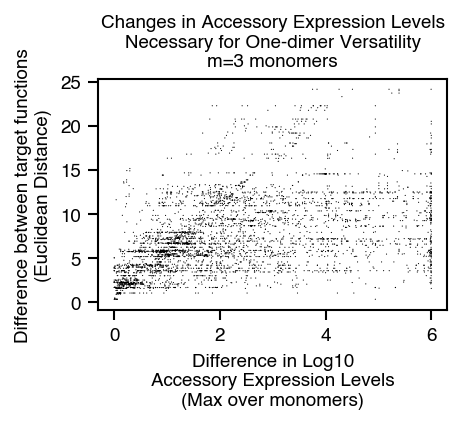

In [ ]:
m_i = m_list.index(m)

# Create figure
fig, ax= plt.subplots(figsize=(3,2))

# Apply statistic
if statistic=='mean':
    expression_diff_statistics = np.mean(np.abs(log_expression_diffs_bym_onedimer[m_i]),axis=1)
elif statistic=='median':
    expression_diff_statistics = np.median(np.abs(log_expression_diffs_bym_onedimer[m_i]),axis=1)
elif statistic=='max':
    expression_diff_statistics = np.max(np.abs(log_expression_diffs_bym_onedimer[m_i]),axis=1)
elif statistic=='euclidean':
    expression_diff_statistics = np.sqrt(np.sum(log_expression_diffs_bym_onedimer[m_i]**2,axis=1))

# Randomly sample
rng = np.random.default_rng()
n_samples = 10000
if n_samples < expression_diff_statistics.shape[0]:
    random_subset = rng.choice(np.arange(expression_diff_statistics.shape[0]),size=n_samples,replace=False)
else:
    random_subset = np.arange(expression_diff_statistics.shape[0])
    n_samples = expression_diff_statistics.shape[0]

_ = ax.scatter(expression_diff_statistics[random_subset],target_function_euclidean_dists_bym_onedimer[m_i][random_subset],s=0.3,color='k',alpha=1,edgecolors='none')

# Set axes limits
# ax.set_xlim([-0.00005,0.0005])
# ax.set_ylim([-0.00005,0.0005])

# Customize spines
set_spine_linewidth(ax,1)

# Customize the major ticks
ax.tick_params(axis='both', which='major', length=5, width=1)  # Length and linewidth of major ticks

# Customize the minor ticks
ax.tick_params(axis='both', which='minor', length=2.5, width=0.5)   # Length and linewidth of minor ticks

_ = ax.set_ylabel('Difference between target functions\n(Euclidean Distance)')
if statistic in ['mean','median','max']:
    xlabel_stat = statistic.capitalize()+' over monomers'
elif statistic=='euclidean':
    xlabel_stat = 'Euclidean Distance'
_ = ax.set_xlabel(f'Difference in Log10\nAccessory Expression Levels\n({xlabel_stat})')
_ = ax.set_title(f'Changes in Accessory Expression Levels\nNecessary for One-dimer Versatility\nm={m} monomers',fontsize=9)

# Save
if save:
    filename = f'accessory_exp_changes_vs_function_dist_onedimer_{m}M_{statistic}'
    plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),bbox_inches='tight',transparent=True)
    fig.patch.set_facecolor('white')
    plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

For any-dimer versatility:

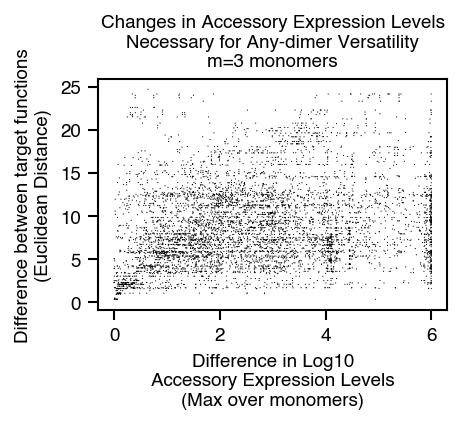

In [ ]:
m_i = m_list.index(m)

# Create figure
fig, ax= plt.subplots(figsize=(3,2))

# Apply statistic
if statistic=='mean':
    expression_diff_statistics = np.mean(np.abs(log_expression_diffs_bym_anydimer[m_i]),axis=1)
elif statistic=='median':
    expression_diff_statistics = np.median(np.abs(log_expression_diffs_bym_anydimer[m_i]),axis=1)
elif statistic=='max':
    expression_diff_statistics = np.max(np.abs(log_expression_diffs_bym_anydimer[m_i]),axis=1)
elif statistic=='euclidean':
    expression_diff_statistics = np.sqrt(np.sum(log_expression_diffs_bym_anydimer[m_i]**2,axis=1))

# Randomly sample
rng = np.random.default_rng()
n_samples = 10000
if n_samples < expression_diff_statistics.shape[0]:
    random_subset = rng.choice(np.arange(expression_diff_statistics.shape[0]),size=n_samples,replace=False)
else:
    random_subset = np.arange(expression_diff_statistics.shape[0])
    n_samples = expression_diff_statistics.shape[0]

_ = ax.scatter(expression_diff_statistics[random_subset],target_function_euclidean_dists_bym_anydimer[m_i][random_subset],s=0.3,color='k',alpha=1,edgecolors='none')

# Set axes limits
# ax.set_xlim([-0.00005,0.0005])
# ax.set_ylim([-0.00005,0.0005])

# Customize spines
set_spine_linewidth(ax,1)

# Customize the major ticks
ax.tick_params(axis='both', which='major', length=5, width=1)  # Length and linewidth of major ticks

# Customize the minor ticks
ax.tick_params(axis='both', which='minor', length=2.5, width=0.5)   # Length and linewidth of minor ticks

_ = ax.set_ylabel('Difference between target functions\n(Euclidean Distance)')
if statistic in ['mean','median','max']:
    xlabel_stat = statistic.capitalize()+' over monomers'
elif statistic=='euclidean':
    xlabel_stat = 'Euclidean Distance'
_ = ax.set_xlabel(f'Difference in Log10\nAccessory Expression Levels\n({xlabel_stat})')
_ = ax.set_title(f'Changes in Accessory Expression Levels\nNecessary for Any-dimer Versatility\nm={m} monomers',fontsize=9)

# Save
if save:
    filename = f'accessory_exp_changes_vs_function_dist_anydimer_{m}M_{statistic}'
    plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),bbox_inches='tight',transparent=True)
    fig.patch.set_facecolor('white')
    plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

Automatically generate all plots:

In [ ]:
for m in tqdm(m_list):
    for statistic in ['mean','median','max','euclidean']:
        m_i = m_list.index(m)

        # Create figure
        fig, ax= plt.subplots(figsize=(3,2))

        # Apply statistic
        if statistic=='mean':
            expression_diff_statistics = np.mean(np.abs(log_expression_diffs_bym_onedimer[m_i]),axis=1)
        elif statistic=='median':
            expression_diff_statistics = np.median(np.abs(log_expression_diffs_bym_onedimer[m_i]),axis=1)
        elif statistic=='max':
            expression_diff_statistics = np.max(np.abs(log_expression_diffs_bym_onedimer[m_i]),axis=1)
        elif statistic=='euclidean':
            expression_diff_statistics = np.sqrt(np.sum(log_expression_diffs_bym_onedimer[m_i]**2,axis=1))

        # Randomly sample
        rng = np.random.default_rng()
        n_samples = 10000
        if n_samples < expression_diff_statistics.shape[0]:
            random_subset = rng.choice(np.arange(expression_diff_statistics.shape[0]),size=n_samples,replace=False)
        else:
            random_subset = np.arange(expression_diff_statistics.shape[0])
            n_samples = expression_diff_statistics.shape[0]

        _ = ax.scatter(expression_diff_statistics[random_subset],target_function_euclidean_dists_bym_onedimer[m_i][random_subset],s=0.3,color='k',alpha=1,edgecolors='none')

        # Set axes limits
        # ax.set_xlim([-0.00005,0.0005])
        # ax.set_ylim([-0.00005,0.0005])

        # Customize spines
        set_spine_linewidth(ax,1)

        # Customize the major ticks
        ax.tick_params(axis='both', which='major', length=5, width=1)  # Length and linewidth of major ticks

        # Customize the minor ticks
        ax.tick_params(axis='both', which='minor', length=2.5, width=0.5)   # Length and linewidth of minor ticks

        _ = ax.set_ylabel('Difference between target functions\n(Euclidean Distance)')
        if statistic in ['mean','median','max']:
            xlabel_stat = statistic.capitalize()+' over monomers'
        elif statistic=='euclidean':
            xlabel_stat = 'Euclidean Distance'
        _ = ax.set_xlabel(f'Difference in Log10\nAccessory Expression Levels\n({xlabel_stat})')
        _ = ax.set_title(f'Changes in Accessory Expression Levels\nNecessary for One-dimer Versatility\nm={m} monomers',fontsize=9)

        # Save
        filename = f'accessory_exp_changes_vs_function_dist_onedimer_{m}M_{statistic}'
        plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),bbox_inches='tight',transparent=True)
        fig.patch.set_facecolor('white')
        plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

        # Close figure
        plt.close()

In [ ]:
for m in tqdm(m_list):
    for statistic in ['mean','median','max','euclidean']:
        m_i = m_list.index(m)

        # Create figure
        fig, ax= plt.subplots(figsize=(3,2))

        # Apply statistic
        if statistic=='mean':
            expression_diff_statistics = np.mean(np.abs(log_expression_diffs_bym_anydimer[m_i]),axis=1)
        elif statistic=='median':
            expression_diff_statistics = np.median(np.abs(log_expression_diffs_bym_anydimer[m_i]),axis=1)
        elif statistic=='max':
            expression_diff_statistics = np.max(np.abs(log_expression_diffs_bym_anydimer[m_i]),axis=1)
        elif statistic=='euclidean':
            expression_diff_statistics = np.sqrt(np.sum(log_expression_diffs_bym_anydimer[m_i]**2,axis=1))

        # Randomly sample
        rng = np.random.default_rng()
        n_samples = 10000
        if n_samples < expression_diff_statistics.shape[0]:
            random_subset = rng.choice(np.arange(expression_diff_statistics.shape[0]),size=n_samples,replace=False)
        else:
            random_subset = np.arange(expression_diff_statistics.shape[0])
            n_samples = expression_diff_statistics.shape[0]

        _ = ax.scatter(expression_diff_statistics[random_subset],target_function_euclidean_dists_bym_anydimer[m_i][random_subset],s=0.3,color='k',alpha=1,edgecolors='none')

        # Set axes limits
        # ax.set_xlim([-0.00005,0.0005])
        # ax.set_ylim([-0.00005,0.0005])

        # Customize spines
        set_spine_linewidth(ax,1)

        # Customize the major ticks
        ax.tick_params(axis='both', which='major', length=5, width=1)  # Length and linewidth of major ticks

        # Customize the minor ticks
        ax.tick_params(axis='both', which='minor', length=2.5, width=0.5)   # Length and linewidth of minor ticks

        _ = ax.set_ylabel('Difference between target functions\n(Euclidean Distance)')
        if statistic in ['mean','median','max']:
            xlabel_stat = statistic.capitalize()+' over monomers'
        elif statistic=='euclidean':
            xlabel_stat = 'Euclidean Distance'
        _ = ax.set_xlabel(f'Difference in Log10\nAccessory Expression Levels\n({xlabel_stat})')
        _ = ax.set_title(f'Changes in Accessory Expression Levels\nNecessary for Any-dimer Versatility\nm={m} monomers',fontsize=9)

        # Save
        filename = f'accessory_exp_changes_vs_function_dist_anydimer_{m}M_{statistic}'
        plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),bbox_inches='tight',transparent=True)
        fig.patch.set_facecolor('white')
        plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

        # Close figure
        plt.close()